In this second assignment, you are challenged to employ Hugging Face transformers for the same classification task as in the first assignment.

You should explore Hugging Face models to find a pre-trained model that is suitable and promising for fine-tuning with data for the ADU type classification task. It should make sense to pick one that has been pre-trained with Portuguese (either in isolation or in a multi-lingual fashion), possibly with data from a similar genre.

As a bonus, you can also employ a domain adaptation approach, by leveraging on the full text of opinion articles made available.

You should compare the performance of your model(s) with the ones developed for the first assignment. For the final delivery, prepare a short presentation (max 10 slides) documenting your approach.



## Loading the dataset 

In [1]:
%ls

drive/  sample_data/


In [2]:
!pip install datasets
!pip install transformers
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/data/OpArticles_ADUs.xlsx")
dataset.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


## Data cleaning

Some text spans were annotated more than once. In these cases, there are 2 possibilities:


1.   The text span is kept, if all annotations consider that the example belongs to the same class; 
2.   The text span is eliminated, if different annotators assign different labels to the example. 



In [5]:
import numpy as np

grouped_df = dataset.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": [], "article_id": []}

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    if len(dict_counts.keys()) > 1:
        continue
    dataset_dict["article_id"].append(group["article_id"].values[0])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(list(dict_counts.keys())[0])
    
dataset = pd.DataFrame(dataset_dict, columns = ["tokens", "label", "article_id"])
dataset.head()

,tokens,label,article_id
0,presumo que essas partilhas tenham gerado um e...,Value,5cdd971b896a7fea062d6e3d
1,essas partilhas tenham gerado um efeito bola d...,Value,5cdd971b896a7fea062d6e3d
2,esta questão ter [justificadamente] despertado...,Value,5cdd971b896a7fea062d6e3d
3,a ocasião propicia um debate amplo na sociedad...,Value,5cdd971b896a7fea062d6e3d
4,a tomada urgente de medidas por parte da tutel...,Value,5cdd971b896a7fea062d6e3d


In [6]:
dataset["label"].value_counts()

Value       5003
Fact        2235
Value(-)    1768
Value(+)     849
Policy       398
Name: label, dtype: int64

The dataset is now ready for splitting. Without any augmentation, it contains roughly 10.000 samples. Similarly to assignment 1, it is unbalanced, having significantly more "Value" examples.

In order to easily use and split the dataset, we need to convert it into a Hugging Face dataset.

In [7]:
from datasets import Dataset

labels = ['Value','Fact','Value(+)','Value(-)','Policy']
numeric_labels = []

for label in dataset["label"]:
    new_label = labels.index(label)
    numeric_labels.append(new_label)

dataset["label"] = numeric_labels

dataset_hf = Dataset.from_pandas(dataset)

## Splitting the dataset

We can now split the dataset into training, testing and validating sets.

In [8]:
from datasets import DatasetDict

# 90% train, 10% test+validation
train_test = dataset_hf.train_test_split(test_size=0.1)

# Split the 10% test+validation set in half test, half validation
valid_test = train_test['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
train_valid_test_dataset = DatasetDict({
    'train': train_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

BERTimbau Base is a pretrained BERT model for Brazilian Portuguese that achieves state-of-the-art performances on three downstream NLP tasks: Named Entity Recognition, Sentence Textual Similarity and Recognizing Textual Entailment. It is available in two sizes: Base and Large.

In [9]:
# Baseline model

# model_name = "/content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles"

model_name = "bert-base-multilingual-cased"
tokenizer_name = "bert-base-multilingual-cased"

## Loading the model and tokenizer

In [10]:
#!pip install transformers --quiet

from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, do_lower_case=False, padding=True, truncation=True, model_max_len=512)


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

:## Apply the tokenizer loaded into the text spans

In [11]:
def preprocess_function(sample):
    return tokenizer(sample["tokens"], truncation=True, padding=True)


tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)
train_valid_test_dataset

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label', 'article_id'],
        num_rows: 9227
    })
    validation: Dataset({
        features: ['tokens', 'label', 'article_id'],
        num_rows: 513
    })
    test: Dataset({
        features: ['tokens', 'label', 'article_id'],
        num_rows: 513
    })
})

In [12]:
import torch

inputs = tokenizer(train_valid_test_dataset['test'][0]['tokens'], padding=True, truncation=True, return_tensors="pt")

outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits)
print(predictions)


tensor([[0.2175, 0.2292, 0.1843, 0.1723, 0.1966]], grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


## Fine-tuning

The next step is to fine-tune the model using our training data. 

In [13]:

from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results-bert-uncased-multilangual",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# training_args = TrainingArguments("test_trainer", num_train_epochs=1)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



In [14]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2885


Epoch,Training Loss,Validation Loss,Accuracy
1,1.176200,1.061667,0.588694
2,0.936900,1.096708,0.590643
3,0.769200,1.142455,0.592593
4,0.599700,1.302864,0.584795
5,0.472500,1.418338,0.580897


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to ./results-bert-uncased-multilangual/checkpoint-577
Configuration saved in ./results-bert-uncased-multilangual/checkpoint-577/config.json
Model weights saved in ./results-bert-uncased-multilangual/checkpoint-577/pytorch_model.bin
tokenizer config file saved in ./results-bert-uncased-multilangual/checkpoint-577/tokenizer_config.json
Special tokens file saved in ./results-bert-uncased-multilangual/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id,

TrainOutput(global_step=2885, training_loss=0.7367920133435334, metrics={'train_runtime': 1435.8499, 'train_samples_per_second': 32.131, 'train_steps_per_second': 2.009, 'total_flos': 3747977130081252.0, 'train_loss': 0.7367920133435334, 'epoch': 5.0})

### Saving the model

In [15]:
trainer.save_model()

Saving model checkpoint to ./results-bert-uncased-multilangual
Configuration saved in ./results-bert-uncased-multilangual/config.json
Model weights saved in ./results-bert-uncased-multilangual/pytorch_model.bin
tokenizer config file saved in ./results-bert-uncased-multilangual/tokenizer_config.json
Special tokens file saved in ./results-bert-uncased-multilangual/special_tokens_map.json


In [22]:
!cp -R results-bert-uncased-multilangual "/content/drive/MyDrive/Colab Notebooks/models"

## Loading and Using the model

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer2 = AutoTokenizer.from_pretrained("./results-bert-uncased-multilangual")
model2 = AutoModelForSequenceClassification.from_pretrained("./results-bert-uncased-multilangual", num_labels=5)

Didn't find file ./results-bert-uncased-multilangual/added_tokens.json. We won't load it.
loading file ./results-bert-uncased-multilangual/vocab.txt
loading file ./results-bert-uncased-multilangual/tokenizer.json
loading file None
loading file ./results-bert-uncased-multilangual/special_tokens_map.json
loading file ./results-bert-uncased-multilangual/tokenizer_config.json
loading configuration file ./results-bert-uncased-multilangual/config.json
Model config BertConfig {
  "_name_or_path": "./results-bert-uncased-multilangual",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
 

In [17]:
import torch

from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model2, tokenizer=tokenizer2)

y_pred= []
for p in tokenized_dataset['test']['tokens']:
    ti = tokenizer2(p, return_tensors="pt")
    out = model2(**ti)
    pred = torch.argmax(out.logits)
    y_pred.append(pred.item())

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_test = tokenized_dataset['test']['label']

#print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1: ', f1_score(y_test, y_pred, average='macro'))

Accuracy:  0.5789473684210527
Precision:  0.6726958891664774
Recall:  0.3847697581621259
F1:  0.42235900674349364


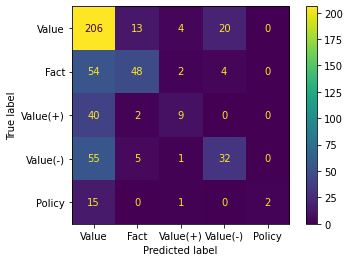

In [20]:
# display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred, labels = [0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


In [25]:
disp.figure_.savefig("/content/drive/MyDrive/Colab Notebooks/statistics/bert-multilingual-cf.png")